In [1]:
import pandas as pd 
from selenium import webdriver
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import requests
from bs4 import BeautifulSoup

import urllib, json
import pandas as pd
import re
from itertools import permutations

from pulp import *

## Functions

#### Function to return game logs from season and amount of pages wanted (2019-20 and 50 pages, for example)

In [2]:
def nba_game_logs1(num_clicks):
    
    # Path to Driver 
    path = '/Users/willhanley/Desktop/chromedriver 3'
    driver = webdriver.Chrome(executable_path=path)
    
    driver.implicitly_wait(10)
    
    # URL
    url = 'https://www.nba.com/stats/players/boxscores/?Season=2020-21&SeasonType=Regular%20Season'
    driver.get(url)
    
    driver.find_element_by_xpath('/html/body/div[5]/div[3]/div/div/div[2]/div/button').click()
    
    # location of table, button to click to next page 
    table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
    next_page = driver.find_elements_by_xpath('/html/body/main/div/div/div[2]/div/div/nba-stat-table/div[3]/div/div/a[2]')

    # empty lists to be appended to 
    player_names = []
    player_stats = []
    
    # Loop through num_clicks times
    for _ in range(num_clicks):
        
        # Define the table we are scraping from 
        table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
        
        # append to player_names and player_stats lists
        for num, info in enumerate(table):
            if num == 0:
                continue
            else:
                if num % 2 == 1:
                    player_names.append(info)
                if num % 2 == 0:
                    player_stats.append([i for i in info.split(' ')])
                
        # Click to next page            
        driver.execute_script("arguments[0].click();", next_page[0])
        
        # Pause 5 seconds 
        time.sleep(4)
 
    # Return dataframe made from player_names and player_stats
    return pd.DataFrame({'Player': player_names,
                  'Team': [i[0] for i in player_stats],
                  'Match-up': [i[2]+i[3] for i in player_stats],
                  'Date': [i[4] for i in player_stats],
                  'W/L': [i[5] for i in player_stats],
                  'Min': [i[6] for i in player_stats],
                  'Pts': [i[7] for i in player_stats],
                  'FGM': [i[8] for i in player_stats],
                  'FGA': [i[9] for i in player_stats],
                  'FG%': [i[10] for i in player_stats],
                  '3PM': [i[11] for i in player_stats],
                  '3PA': [i[12] for i in player_stats],
                  '3P%': [i[13] for i in player_stats],
                  'FTM': [i[14] for i in player_stats],
                  'FTA': [i[15] for i in player_stats],
                  'FT%': [i[16] for i in player_stats],
                  'OREB': [i[17] for i in player_stats],
                  'DREB': [i[18] for i in player_stats],
                  'REB': [i[19] for i in player_stats],
                  'AST': [i[20] for i in player_stats],
                  'STL': [i[21] for i in player_stats],
                  'BLK': [i[22] for i in player_stats],
                  'TOV': [i[23] for i in player_stats],
                  'PF': [i[24] for i in player_stats],
                  '+/-': [i[25] for i in player_stats]})

#### Functions for if players had a double-double or a triple-double

In [3]:
# Function if player has a double double 

def double_double(row):
    val = 0
    if (row['Pts'] >= 10) & (row['AST'] >= 10) | \
    (row['Pts'] >=10) & (row['REB'] >= 10) | (row['AST'] >=10) & (row['REB'] >= 10):
        val += 1
    return val

# Function if player has a triple double 

def triple_double(row):
    val = 0
    if (row['Pts'] >= 10) & (row['AST'] >= 10) & (row['REB'] >=10) | \
    (row['Pts'] >=10) & (row['AST'] >= 10) & (row['STL'] >= 10) | \
    (row['Pts'] >=10) & (row['REB'] >= 10) & (row['BLK'] >= 10) | \
    (row['Pts'] >=10) & (row['AST'] >= 10) & (row['BLK'] >= 10):
        val += 1
    return val

#### Function to return team defense statistics from season input (2019-20, for example)

In [4]:
def nba_defense(season_year):
    
    # Path to Driver 
    path = '/Users/willhanley/Desktop/chromedriver 3'
    driver = webdriver.Chrome(executable_path=path)
    
    driver.implicitly_wait(10)
    
    # URL
    url = f'https://www.nba.com/stats/teams/defense/?sort=W&dir=-1&Season={season_year}&SeasonType=Regular%20Season'
    driver.get(url)
    
    driver.find_element_by_xpath('/html/body/div[5]/div[3]/div/div/div[2]/div/button').click()
    
    # location of table, button to click to next page 
    table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
    
    # empty lists to append to 
    teams = []
    team_stats = []
    
    # find locations of team names and team stats 
    for num, info in enumerate(table):
        if num > 8:
            if num % 3 == 0:
                teams.append(info)
            if (num -1) % 3 == 0:
                team_stats.append([i for i in info.split(' ')])

    # return dataframe 
    return pd.DataFrame({
        'Season': season_year,
        'Team': teams,
        'GP': [i[0] for i in team_stats],
        'W': [i[1] for i in team_stats],
        'L': [i[2] for i in team_stats],
        'MIN': [i[3] for i in team_stats],
        'DEF_RTG': [i[4] for i in team_stats],
        'DREB': [i[5] for i in team_stats],
        'DREB%': [i[6] for i in team_stats],
        'STL': [i[7] for i in team_stats],
        'BLK': [i[8] for i in team_stats],
        'OPP_PTS_off_TOV': [i[9] for i in team_stats],
        'OPP_PTS_2nd_CHANCE': [i[10] for i in team_stats],
        'OPP_PTS_FB': [i[11] for i in team_stats],
        'OPP_PTS_PAINT': [i[12] for i in team_stats]})

#### Function to find a list of the players that are playing tonight. 

In [5]:
# Function to find a list of the players that are playing tonight

def playing_tonight():    
    url = 'https://www.sportsline.com/nba/expert-projections/simulation/'

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table")[0]

    data = [[cell.text for cell in row.find_all(["th","td"])]
                            for row in table.find_all("tr")]
    df = pd.DataFrame(data)

    df.columns = df.iloc[0,:]
    df.drop(index=0,inplace=True)
    return df

players_playing_tonight_df = playing_tonight()

players_playing_tonight_df = players_playing_tonight_df[['PLAYER  ','POS  ']]

players_playing_tonight = list(players_playing_tonight_df['PLAYER  '])


#### Function to collect all DraftKing Salaries for players

In [6]:
# Function to find DraftKing Salaries of all players playing tonight

def dk_salary():    
    url = 'https://www.fantasypros.com/daily-fantasy/nba/draftkings-salary-changes.php'

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table")[0]

    data = [[cell.text for cell in row.find_all(["th","td"])]
                            for row in table.find_all("tr")]
    df = pd.DataFrame(data)

    df.columns = df.iloc[0,:]
    df.drop(index=0,inplace=True)
    return df

dk_salary = dk_salary()

dk_salary['Today'] = dk_salary['Today'].str.replace('$', '')
dk_salary['Today'] = dk_salary['Today'].str.replace(',', '_')
dk_salary['Today'] = dk_salary['Today'].astype(float)
dk_salary['Salary'] = dk_salary['Today']

dk_salary = dk_salary[['Player','Salary']]

dk_salary['Position'] = dk_salary['Player'].apply(lambda st: st[st.find("(")+1:st.find(")")])

dk_salary['Position'] = dk_salary['Position'].apply(lambda st:[st.split('- ',1)[-1]])

dk_salary['Player'] = dk_salary['Player'].str.replace(r"\(.*?\)","").str.strip()

dk_salary['Position'] = [','.join(map(str, l)) for l in dk_salary['Position']]

dk_salary.head()

,Player,Salary,Position
1,Terrance Ferguson,3000.0,SF
2,Isaiah Hartenstein,3000.0,C
3,Vlatko Cancar,3000.0,SF
4,Ty-Shon Alexander,3000.0,PG/SG
5,Naji Marshall,3000.0,SF/PF


## Update the current season to todays date and read in past data

In [8]:
# Web-scrape current season for updated information

twenty = nba_game_logs1(108)
twenty.head()

,Player,Team,Match-up,Date,W/L,Min,Pts,FGM,FGA,FG%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,Juwan Morgan,UTA,vs.NYK,01/26/2021,W,1,0,0,0,-,...,-,0,0,0,0,0,0,0,0,-2
1,Miye Oni,UTA,vs.NYK,01/26/2021,W,1,0,0,0,-,...,-,0,0,0,0,0,0,1,0,-2
2,Georges Niang,UTA,vs.NYK,01/26/2021,W,13,9,3,6,50.0,...,-,0,1,1,0,2,0,0,1,14
3,Kevin Knox II,NYK,@UTA,01/26/2021,L,8,0,0,1,0.0,...,-,0,1,1,0,0,0,1,1,-7
4,Obi Toppin,NYK,@UTA,01/26/2021,L,13,4,2,2,100,...,-,0,2,2,0,0,0,1,0,0


#### Read in seasons 2016-17 to 2019-20

In [9]:
sixteen = pd.read_csv('data/2016=2017stats.csv')
seventeen = pd.read_csv('data/2017-2018stats.csv')
eighteen = pd.read_csv('data/2018-2019stats.csv')
nineteen = pd.read_csv('data/game_logs2019-2020.csv')
twenty = pd.read_csv('data/20-21_game_logs.csv')

#### Feature Engineering and Concat all game logs together 

In [10]:
# Date column to datetime

sixteen['Date'] = pd.to_datetime(sixteen['Date'])
seventeen['Date'] = pd.to_datetime(seventeen['Date'])
eighteen['Date'] = pd.to_datetime(eighteen['Date'])
nineteen['Date'] = pd.to_datetime(nineteen['Date'])
twenty['Date'] = pd.to_datetime(twenty['Date'])

# Create Season column

sixteen['Season'] = '2016-17'
seventeen['Season'] = '2017-18'
eighteen['Season'] = '2018-19'
nineteen['Season'] = '2019-20'
twenty['Season'] = '2020-21'

# Concat 1 dataframe
frames = [eighteen,nineteen,twenty]
game_logs_all = pd.concat(frames)
game_logs_all.sort_index(inplace=True)

# Drop columns with percentages

game_logs_all.drop(columns=['FT%', '3P%', 'FG%'], inplace=True)

# Save numerical columns as ints

game_logs_all[['Min', 'Pts', 'FGM','FGA','3PM', '3PA', 'FTM', 'FTA', 'OREB',
       'DREB','REB','AST','STL','BLK','TOV','PF', '+/-']] = game_logs_all[['Min', 'Pts', 'FGM','FGA','3PM', '3PA', 'FTM', 'FTA', 'OREB',
       'DREB','REB','AST','STL','BLK','TOV','PF', '+/-']].astype(str).astype(int)

# Create Double double column
game_logs_all['dubdub'] = game_logs_all.apply(double_double, axis=1)

# Create Triple double column
game_logs_all['tripdub'] = game_logs_all.apply(triple_double, axis=1)

# Create Draft kings score column (based on draftkings formula)
game_logs_all['DraftKings'] = game_logs_all['Pts'] + .5*game_logs_all['3PM'] + 1.25*game_logs_all['REB'] + 1.5*game_logs_all['AST'] \
+ 2*game_logs_all['STL'] + 2*game_logs_all['BLK'] -.5*game_logs_all['TOV'] + 1.5*game_logs_all['dubdub'] + 3*game_logs_all['tripdub']

# Home or away column: 1 for away, 0 for home
game_logs_all['Home/Away'] = game_logs_all['Match-up'].str.contains('@').astype(int)

# Full names for 'Match-up'
game_logs_all['Match-up'] = game_logs_all['Match-up'].map({'vs.UTA': 'Utah Jazz', '@POR':'Portland Trailblazers',
                        '@GSW':'Golden State Warriors', 'vs.SAS':'San Antonio Spurs',
                        '@IND':'Indiana Pacers','vs.DAL':'Dallas Mavericks','vs.CHA':'Charlotte Hornets',
                        'vs.DET':'Detroit Pistons','@TOR':'Toronto Raptors','@MIL': 'Milwaukee Bucks',
                        '@MEM': 'Memphis Grizzlies','vs.MIN':'Minnesota Timberwolves','vs.DEN': 'Denver Nuggets',
                        '@NOP': 'New Orleans Pelicans','vs.MIA': 'Miami Heat','@LAL':'Los Angeles Lakers',
                        'vs.HOU':'Houston Rockets','@ORL':'Orlando Magic','@PHX':'Phoenix Suns','vs.SAC':'Sacramento Kings',
                        'vs.OKC':'Oklahoma City Thunder','@PHI':'Philadelphia 76ers','@BOS':'Boston Celtics',
                        'vs.BKN':'Brooklyn Nets','vs.WAS':'Washington Wizards','@ATL':'Atlanta Hawks',
                        '@SAC':'Sacramento Kings','vs.BOS':'Boston Celtics','@CHI':'Chicago Bulls',
                        'vs.LAC': 'LA Clippers','vs.CLE':'Cleveland Cavaliers','@DAL':'Dallas Mavericks',
                        'vs.PHX': 'Phoenix Suns','vs.GSW':'Golden State Warriors','@OKC':'Oklahoma City Thunder',
                        '@UTA':'Utah Jazz','vs.LAL':'Los Angeles Lakers','@MIA':'Miami Heat','vs.IND':'Indiana Pacers',
                        '@BKN':'Brooklyn Nets','vs.ORL':'Orlando Magic','@DET':'Detroit Pistons','vs.MEM':'Memphis Grizzlies',
                        '@CLE':'Cleveland Cavaliers','@CHA':'Charlotte Hornets','@DEN':'Denver Nuggets','vs.POR':'Portland Trailblazers',
                        'vs.NOP':'New Orleans Pelicans','@SAS':'San Antonio Spurs','vs.ATL':'Atlanta Hawks','@NYK':'New York Knicks',
                        'vs.MIL':'Milwaukee Bucks','@LAC':'LA Clippers','@HOU':'Houston Rockets','vs.CHI':'Chicago Bulls',
                        'vs.NYK':'New York Knicks','@MIN':'Minnesota Timberwolves','vs.PHI':'Philadelphia 76ers','@WAS':'Washington Wizards',
                        'vs.TOR':'Toronto Raptors'})

# Save as csv
game_logs_all.to_csv('data/game_logs_all.csv')

## Update current defensive statistics 

In [11]:
twenty_d = nba_defense('2020-21')
twenty_d.head()

,Season,Team,GP,W,L,MIN,DEF_RTG,DREB,DREB%,STL,BLK,OPP_PTS_off_TOV,OPP_PTS_2nd_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT
0,2020-21,Los Angeles Lakers,18,14,4,48.0,103.9,37.0,76.2,7.0,6.4,16.6,12.2,13.2,48.7
1,2020-21,LA Clippers,18,13,5,48.0,109.2,33.9,75.7,7.6,4.8,15.4,9.7,12.6,45.0
2,2020-21,Utah Jazz,17,13,4,48.0,106.5,38.2,74.9,5.8,5.8,16.9,11.2,12.0,48.1
3,2020-21,Philadelphia 76ers,18,12,6,48.3,107.2,36.1,72.7,8.9,6.6,19.3,13.8,17.1,43.7
4,2020-21,Brooklyn Nets,19,11,8,48.8,110.7,37.3,72.1,6.3,6.1,17.5,16.0,12.5,50.1


#### Read in past defense statistics

In [12]:
sixteen_d = pd.read_csv('data/16-17_defense.csv')
seventeen_d = pd.read_csv('data/17-18_defense.csv')
eighteen_d = pd.read_csv('data/18-19_defense.csv')
nineteen_d = pd.read_csv('data/19-20_defense.csv')

twenty['Min'] = twenty['Min'].astype(int)


#### Concat defenses together 

In [13]:
defenses = [sixteen_d,seventeen_d,eighteen_d,nineteen_d,twenty_d]

defenses = pd.concat(defenses)

defenses['Team'].replace('Portland Trail Blazers','Portland Trailblazers', inplace=True)

## Merge game-logs and defenses together 

In [14]:
total = pd.merge(game_logs_all,defenses,left_on=['Match-up','Season'], right_on=['Team','Season'],how='inner')

#### Feature engineering on Merged game-logs and defenses playing against

In [15]:
# Drop columns that are not relevant
total = total[['Date', 'Player', 'Team_x', 'Match-up', 'W/L', 'Min', 'Pts', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB_x', 'REB', 'AST',
       'STL_x', 'BLK_x', 'TOV', 'PF', '+/-', 'Season', 'dubdub', 'tripdub',
       'DraftKings', 'Home/Away', 'DEF_RTG','DREB%', 'STL_y', 'BLK_y', 'OPP_PTS_off_TOV',
       'OPP_PTS_2nd_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT']]

# Rename columns to more appealing titles
total.rename(columns={'DEF_RTG':'OPP_DEF_RTG',
          'DREB%':'OPP_DREB%',
          'STL_y':'OPP_STL',
          'BLK_y':'OPP_BLK',
                     'DREB_x':'DREB',
                     'STL_x':'STL',
                     'BLK_x':'BLK',
                     'Team_x':'Team',
                     'DraftKings':'DK_SCORE',
                     'dubdub':'Dub/Dub',
                     'tripdub':'Trip/Dub'}, inplace=True)

# Binarize 'W/L' column
total['W/L'] = total['W/L'].map({'W': 1, 'L': 0})

# Reorder columns 
total = total[['Date','Season', 'Player', 'Team', 'Match-up','Home/Away', 'W/L', 'Min', 'Pts', 'FGM', 'FGA',
       '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', '+/-', 'Dub/Dub', 'Trip/Dub', 'OPP_DEF_RTG', 'OPP_DREB%', 'OPP_STL', 'OPP_BLK',
       'OPP_PTS_off_TOV', 'OPP_PTS_2nd_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT','DK_SCORE']]

# Save to csv for modeling
total.to_csv('data/g_logs_defense.csv',index=False)

total[['Date','Season', 'Player', 'Team', 'Match-up','Home/Away', 'W/L', 'Min', 'Pts', 'FGM', 'FGA',
       '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', '+/-', 'Dub/Dub', 'Trip/Dub', 'DK_SCORE']].head()

,Date,Season,Player,Team,Match-up,Home/Away,W/L,Min,Pts,FGM,...,REB,AST,STL,BLK,TOV,PF,+/-,Dub/Dub,Trip/Dub,DK_SCORE
0,2019-04-10,2018-19,Ivan Rabb,MEM,Golden State Warriors,0,1,29,6,3,...,8,6,0,0,1,3,12,0,0,24.5
1,2019-04-10,2018-19,Bruno Caboclo,MEM,Golden State Warriors,0,1,30,21,8,...,4,2,1,0,2,3,13,0,0,31.5
2,2019-04-10,2018-19,Justin Holiday,MEM,Golden State Warriors,0,1,28,22,8,...,4,1,0,0,2,2,5,0,0,30.0
3,2019-04-10,2018-19,Yuta Watanabe,MEM,Golden State Warriors,0,1,19,4,2,...,4,0,0,0,0,2,2,0,0,9.0
4,2019-04-10,2018-19,Tyler Dorsey,MEM,Golden State Warriors,0,1,28,18,7,...,4,3,1,0,0,2,17,0,0,30.5


## VAR Modeling

In [16]:
data = pd.read_csv('data/g_logs_defense.csv')

#### Model for one player - LeBron James

In [17]:
empty_list = []

df = data[data['Player'] == 'LeBron James']
df.index = pd.DatetimeIndex(df['Date'])
df.drop(columns='Date',inplace=True)
df.sort_index(inplace=True)

player = df['Player'][0]

last_game = df[['DK_SCORE', 'Pts','AST','REB']].iloc[[-1]]

last_dk = 0
last_points = 0
last_reb = 0
last_ast = 0 


# Confirm Stationarity of the data 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput


# Check if draftkings is stationary
dk_test = interpret_dftest(adfuller(df['DK_SCORE']))

if dk_test[1] > .05:
    df['DK_SCORE'] = df['DK_SCORE'].diff(1)
    last_dk = int(last_game['DK_SCORE'])
    print('draftkings score is differenced data')


# Check if points is stationary
pts_test = interpret_dftest(adfuller(df['Pts']))

if pts_test[1] > .05:
    df['Pts'] = df['Pts'].diff(1)
    last_points = int(last_game['Pts'])
    print('points is differenced data')


# Check if rebounds is stationary
reb_test = interpret_dftest(adfuller(df['REB']))

if reb_test[1] > .05:
    df['REB'] = df['REB'].diff(1)
    last_reb = int(last_game['REB'])
    print('rebounds is differenced data')


# Check if assists is stationary 
ast_test = interpret_dftest(adfuller(df['AST']))

if ast_test[1] > .05:
    df['AST'] = df['AST'].diff(1)
    last_ast = int(last_game['AST'])
    print('assists is differenced data')


df = df[['DK_SCORE','Pts','REB','AST']]

df.dropna(inplace=True)

train, test = train_test_split(df,shuffle=False, test_size = .3)

model = VAR(train)


# The maxlags parameter was chosen by taking the maxlag with the lowest mean squared error. 
ts_model = model.fit(maxlags=3)

forecast = ts_model.forecast(train.values, len(test))

next_game = ts_model.forecast(train.values, 1)

print(f'LeBron is projected for {last_dk + round(next_game[0][0],2)} DraftKings points tonight')
print(f'LeBron is projected to score {last_points + round(next_game[0][1],2)} points tonight')
print(f'LeBron is projected to have {last_reb + round(next_game[0][2],2)} rebounds tonight')
print(f'LeBron is projected to have {last_ast + round(next_game[0][3],2)} assists tonight')

print('---------------------------------------------------')
print(f'The mean squared error for DraftKings Score for LeBron James is: \
{round(mean_squared_error(test.values[:, 0], forecast[:, 0]), 4)}')



assists is differenced data
LeBron is projected for 63.21 DraftKings points tonight
LeBron is projected to score 31.46 points tonight
LeBron is projected to have 10.09 rebounds tonight
LeBron is projected to have 12.86 assists tonight
---------------------------------------------------
The mean squared error for DraftKings Score for LeBron James is: 109.8407


#### Forecast for next game for LeBron James 

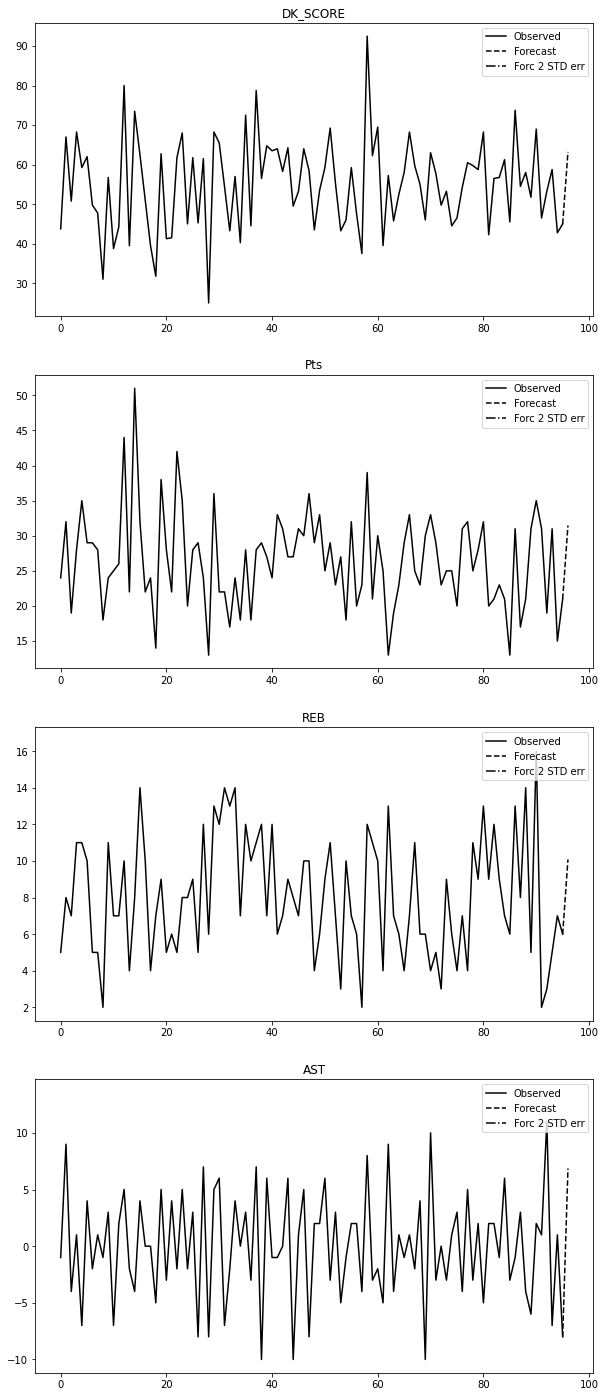

In [18]:
ts_model.plot_forecast(1)

plt.subplots_adjust(top=2)

#### Function to run the model for all players playing tonight

In [33]:
def projection_model(player_list): 
    
    empty_list = []
    for player in player_list:
        if ((twenty[twenty['Player']== player]['Min'].mean()) >= 10)&((data[data['Player'] == player]['Date'].count()) > 10)&\
        (twenty[twenty['Player'] == player]['Date'].count()> 2):
            df = data[data['Player'] == player]
            df.index = pd.DatetimeIndex(df['Date'])
            df.drop(columns='Date',inplace=True)
            df.sort_index(inplace=True)

            player = df['Player'][0]

            last_game = df[['DK_SCORE', 'Pts','AST','REB']].iloc[[-1]]

            last_dk = 0
            last_points = 0
            last_reb = 0
            last_ast = 0 


            # Confirm Stationarity of the data 
            def interpret_dftest(dftest):
                dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
                return dfoutput


            # Check if draftkings is stationary
            dk_test = interpret_dftest(adfuller(df['DK_SCORE']))

            if dk_test[1] > .05:
                df['DK_SCORE'] = df['DK_SCORE'].diff(1)
                last_dk = int(last_game['DK_SCORE'])


            # Check if points is stationary
            pts_test = interpret_dftest(adfuller(df['Pts']))

            if pts_test[1] > .05:
                df['Pts'] = df['Pts'].diff(1)
                last_points = int(last_game['Pts'])


            # Check if rebounds is stationary
            reb_test = interpret_dftest(adfuller(df['REB']))

            if reb_test[1] > .05:
                df['REB'] = df['REB'].diff(1)
                last_reb = int(last_game['REB'])


            # Check if assists is stationary 
            ast_test = interpret_dftest(adfuller(df['AST']))

            if ast_test[1] > .05:
                df['AST'] = df['AST'].diff(1)
                last_ast = int(last_game['AST'])

            
            df = df[['DK_SCORE','Pts','REB','AST']]

            df.dropna(inplace=True)

            train, test = train_test_split(df,shuffle=False, test_size = .3)

            model = VAR(train)

            ts_model = model.fit(maxlags=3)

            forecast = ts_model.forecast(train.values, len(test))

            next_game = ts_model.forecast(train.values, 1)
            
            empty_list.append([player,last_dk + round(next_game[0][0],2),last_points + round(next_game[0][1],2),
                             last_reb + round(next_game[0][2],2),last_ast + round(next_game[0][3],2),
                              round(mean_squared_error(test.values[:, 0], forecast[:, 0]), 2),
                              round(mean_squared_error(test.values[:, 1], forecast[:, 1]), 2),
                              round(mean_squared_error(test.values[:, 2], forecast[:, 2]), 2),
                              round(mean_squared_error(test.values[:, 3], forecast[:, 3]), 2)])
            

    return pd.DataFrame(empty_list, columns=['Player','DK_proj','Pts_proj','Reb_proj','Ast_proj','MSE_DK',
                                            'MSE_Pts','MSE_Reb','MSE_Ast'])

projection_model(players_playing_tonight).sort_values(by='DK_proj', ascending=False).head()

,Player,DK_proj,Pts_proj,Reb_proj,Ast_proj,MSE_DK,MSE_Pts,MSE_Reb,MSE_Ast
170,Tyrese Maxey,67.65,48.72,10.21,4.13,4981.57,2826.22,51.32,102.13
11,Bam Adebayo,66.28,43.37,6.80,2.99,264.27,92.66,26.70,13.65
5,LeBron James,63.21,31.46,10.09,12.86,109.84,42.74,6.77,13.67
7,Giannis Antetokounmpo,59.80,31.06,13.14,4.98,165.56,61.18,14.47,6.18
9,Joel Embiid,59.69,29.36,14.10,4.23,368.57,129.75,20.36,3.43


In [34]:
# To choose the best parameters for the model, the lowest mean squared error for Draftkings score was found. 

projections = projection_model(players_playing_tonight)

projections['MSE_DK'].median()

118.17

In [35]:

projections = projection_model(players_playing_tonight)

projections = pd.merge(players_playing_tonight_df,projections,right_on='Player',left_on='PLAYER  ',how='inner').drop(columns='Player')

projections = pd.merge(projections,dk_salary,left_on='PLAYER  ',right_on='Player',how='inner').drop(columns='Player')

projections['Cost_per_point'] = round(projections['Salary']/projections['DK_proj'],2)

projections.sort_values(by='Cost_per_point', ascending=True,inplace=True)

projections['Points_Rank'] = projections['DK_proj'].rank(ascending=False)

projections['Salary_Rank'] = projections['Salary'].rank(ascending=False)

projections['Eligible'] = np.where(np.abs((projections['Points_Rank']) - (projections['Salary_Rank']))<= 30,True,False)

projections = projections[projections['Eligible'] == True]

projections.to_csv('projections_1-20.csv',index=False) 

projections = projections[['PLAYER  ','Position','DK_proj','Salary','Points_Rank','Salary_Rank','Eligible', 'Cost_per_point']]

projections.sort_values(by='Cost_per_point', ascending=True).head(10)

,PLAYER,Position,DK_proj,Salary,Points_Rank,Salary_Rank,Eligible,Cost_per_point
11,Bam Adebayo,C,66.28,8600.0,2.0,16.5,True,129.75
35,Pascal Siakam,PF/C,53.00,7900.0,10.0,26.5,True,149.06
50,John Collins,PF/C,50.65,7700.0,13.0,29.5,True,152.02
5,LeBron James,PG/SF,63.21,9900.0,3.0,7.0,True,156.62
23,Kristaps Porzingis,PF/C,52.30,8200.0,12.0,21.5,True,156.79
9,Joel Embiid,C,59.69,9400.0,5.0,9.0,True,157.48
56,Eric Bledsoe,PG/SG,36.49,5800.0,36.0,66.0,True,158.95
36,Rudy Gobert,C,44.93,7200.0,18.0,37.5,True,160.25
118,OG Anunoby,SF/PF,41.02,6600.0,28.0,48.5,True,160.90
31,Shai Gilgeous-Alexander,PG,52.34,8500.0,11.0,18.0,True,162.40


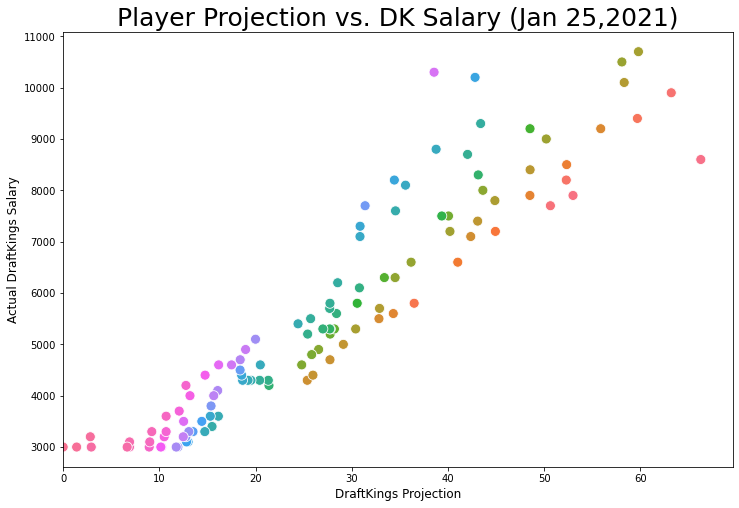

In [36]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=projections,x='DK_proj',y='Salary', hue='PLAYER  ',s=100, legend=False)

plt.xlabel('DraftKings Projection',size=12)
plt.ylabel('Actual DraftKings Salary',size=12)
plt.title('Player Projection vs. DK Salary (Jan 25,2021)', size=25)
plt.xlim(0);

## Optimizer to select optimal lineup

#### Update positions due to some players having multiple positions

In [37]:
# Update column names to enter into code below 

projections = projections[projections['PLAYER  '] != 'OG Anunoby']

projections = projections.rename(columns={'Position':'position',
                                          'PLAYER  ':'displayName',
                                          'Salary':'salary',
                                          'DK_proj':'points'})

# Group positions together to account for players with multiple positions. Util is all players.
# Guard is all guards. Forward is all forwards/centers. Both is both guard/forward (very few players)

util = projections[projections['position'].isin(['SG/SF', 'C', 'PG', 'PF', 'SF/PF', 'PF/C', 'PG/SG', 'SG', 'SF',
       'PG/SF'])].copy()
util['position'] = 'util'
projections = pd.concat([projections, util])

guard = projections[projections['position'].isin(['PG','PG/SG', 'SG'])].copy()
guard['position'] = 'guard'
projections = pd.concat([projections, guard])

forward = projections[projections['position'].isin(['PF', 'SF/PF', 'SF'])].copy()
forward['position'] = 'forward'
projections = pd.concat([projections, forward])

center = projections[projections['position'].isin(['C','PF/C'])].copy()
center['position'] = 'center'
projections = pd.concat([projections, center])

both = projections[projections['position'].isin(['PG/SF','SG/SF'])].copy()
both['position'] = 'both'
projections = pd.concat([projections, both])

availables = projections[["position", "displayName", "salary",
  "points"]].groupby(["position", "displayName", "salary",
  "points"]).agg("count")
availables = availables.reset_index()

### Option 1: Top 8 players regardless of position. Best possible outcome if this works position wise.

In [38]:
# Code modified from Branko Blagojevic "Using Python and Linear Programming to Optimize Fantasy Football Picks"

salaries = {}
points = {}
for pos in availables.position.unique():
    available_pos = availables[availables.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
pos_num_available = {
    "PG": 0,
    "PG/SG": 0,
    "SG": 0,
    "C": 0,
    'PF': 0,
    'PF/C':0,
    'PG/SF':0,
    'SF':0,
    'SF/PF':0,
    'SG/SF':0,
    'util':8,
    'guard':0,
    'forward':0,
    'both':0,
    'center':0}

SALARY_CAP = 50000

_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []

# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) == pos_num_available[k]

    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

prob.solve()

def summary(prob):
    div = '---------------------------------------\n'
    print("Players:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name)
    print(div)
    print(div)
    print("Salaries:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print(div)
    print("Projected Points:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))
    
summary(prob)

Players:

util_Bam_Adebayo
util_Danny_Green
util_Dwight_Howard
util_Eric_Bledsoe
util_Joe_Harris
util_John_Collins
util_Lonzo_Ball
util_Pascal_Siakam
---------------------------------------

---------------------------------------

Salaries:
8600.0*1.0 + 4300.0*1.0 + 4400.0*1.0 + 5800.0*1.0 + 5700.0*1.0 + 7700.0*1.0 + 5600.0*1.0 + 7900.0*1.0 = 50000.0
---------------------------------------

---------------------------------------

Projected Points:
66.28*1.0 + 25.38*1.0 + 25.97*1.0 + 36.49*1.0 + 32.92*1.0 + 50.65*1.0 + 34.32*1.0 + 53.0*1.0 = 325.01000000000005


#### Option 2: 3 guards,  4 forwards , 1 both

In [25]:
salaries = {}
points = {}
for pos in availables.position.unique():
    available_pos = availables[availables.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
pos_num_available = {
    "PG": 0,
    "PG/SG": 0,
    "SG": 0,
    "C": 0,
    'PF': 0,
    'PF/C':0,
    'PG/SF':0,
    'SF':0,
    'SF/PF':0,
    'SG/SF':0,
    'util':0,
    'guard':3,
    'forward':3,
    'both':0,
    'center':2}

SALARY_CAP = 50000

_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []

# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) == pos_num_available[k]

    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

prob.solve()

def summary(prob):
    div = '---------------------------------------\n'
    print("Players:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name)
    print(div)
    print(div)
    print("Salaries:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print(div)
    print("Projected Points:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))
    
summary(prob)

Players:

center_Bam_Adebayo
center_Joel_Embiid
forward_Danny_Green
forward_OG_Anunoby
forward_Rudy_Gay
guard_Eric_Bledsoe
guard_Jalen_Brunson
guard_Lonzo_Ball
---------------------------------------

---------------------------------------

Salaries:
8600.0*1.0 + 9400.0*1.0 + 4300.0*1.0 + 6600.0*1.0 + 5000.0*1.0 + 5800.0*1.0 + 4700.0*1.0 + 5600.0*1.0 = 50000.0
---------------------------------------

---------------------------------------

Projected Points:
66.28*1.0 + 59.69*1.0 + 25.38*1.0 + 41.019999999999996*1.0 + 29.13*1.0 + 36.49*1.0 + 27.74*1.0 + 34.32*1.0 = 320.05


#### Option 3: 3 guards, 3 forwards, 2 both 

In [26]:
salaries = {}
points = {}
for pos in availables.position.unique():
    available_pos = availables[availables.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
pos_num_available = {
    "PG": 0,
    "PG/SG": 0,
    "SG": 0,
    "C": 0,
    'PF': 0,
    'PF/C':0,
    'PG/SF':0,
    'SF':0,
    'SF/PF':0,
    'SG/SF':0,
    'util':0,
    'guard':3,
    'forward':3,
    'both': 2,
    'center':0}

SALARY_CAP = 50000

_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []

# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) == pos_num_available[k]

    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

prob.solve()

def summary(prob):
    div = '---------------------------------------\n'
    print("Players:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name)
    print(div)
    print(div)
    print("Salaries:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print(div)
    print("Projected Points:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))
    
summary(prob)

Players:

both_Joe_Harris
both_LeBron_James
forward_Danny_Green
forward_OG_Anunoby
forward_Rudy_Gay
guard_Eric_Bledsoe
guard_Fred_VanVleet
guard_Jalen_Brunson
---------------------------------------

---------------------------------------

Salaries:
5700.0*1.0 + 9900.0*1.0 + 4300.0*1.0 + 6600.0*1.0 + 5000.0*1.0 + 5800.0*1.0 + 7900.0*1.0 + 4700.0*1.0 = 49900.0
---------------------------------------

---------------------------------------

Projected Points:
32.92*1.0 + 63.21*1.0 + 25.38*1.0 + 41.019999999999996*1.0 + 29.13*1.0 + 36.49*1.0 + 48.519999999999996*1.0 + 27.74*1.0 = 304.40999999999997


#### Option 4: 4 guards,  3 forwards , 1 both

In [27]:
salaries = {}
points = {}
for pos in availables.position.unique():
    available_pos = availables[availables.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
pos_num_available = {
    "PG": 0,
    "PG/SG": 0,
    "SG": 0,
    "C": 0,
    'PF': 0,
    'PF/C':0,
    'PG/SF':0,
    'SF':0,
    'SF/PF':0,
    'SG/SF':0,
    'util':0,
    'guard':4,
    'forward':2,
    'both': 0,
    'center':2}

SALARY_CAP = 50000

_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []

# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) == pos_num_available[k]

    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

prob.solve()

def summary(prob):
    div = '---------------------------------------\n'
    print("Players:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name)
    print(div)
    print(div)
    print("Salaries:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print(div)
    print("Projected Points:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))
    
summary(prob)

Players:

center_Bam_Adebayo
center_Pascal_Siakam
forward_Danny_Green
forward_Rudy_Gay
guard_Eric_Bledsoe
guard_Fred_VanVleet
guard_Jalen_Brunson
guard_Lonzo_Ball
---------------------------------------

---------------------------------------

Salaries:
8600.0*1.0 + 7900.0*1.0 + 4300.0*1.0 + 5000.0*1.0 + 5800.0*1.0 + 7900.0*1.0 + 4700.0*1.0 + 5600.0*1.0 = 49800.0
---------------------------------------

---------------------------------------

Projected Points:
66.28*1.0 + 53.0*1.0 + 25.38*1.0 + 29.13*1.0 + 36.49*1.0 + 48.519999999999996*1.0 + 27.74*1.0 + 34.32*1.0 = 320.86


## Optimal lineup vs. all player projections

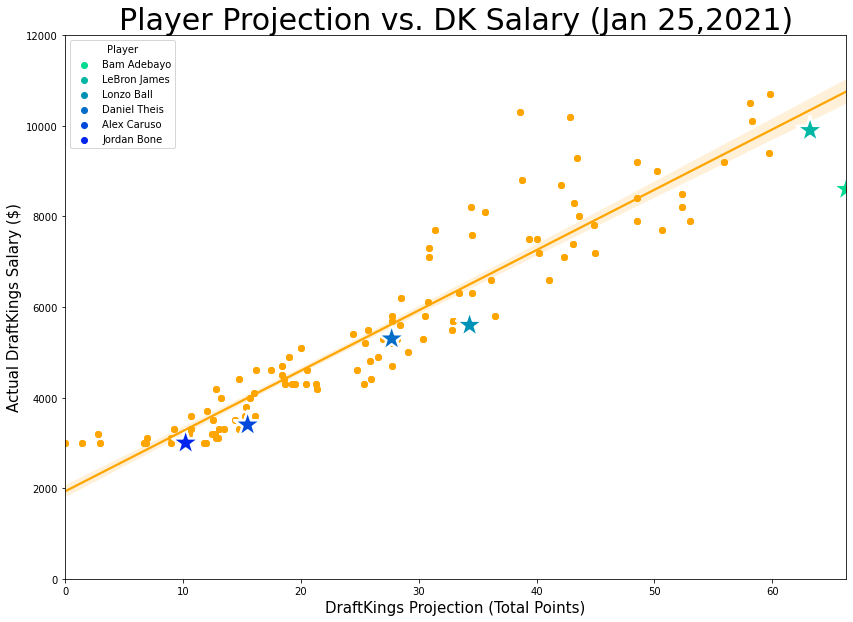

In [28]:
plt.figure(figsize=(14,10))

red_df = projections.loc[(projections['displayName'] == 'LeBron James')|(projections['displayName'] == 'Bam Adebayo')|
                        (projections['displayName'] == 'Daniel Theis')|(projections['displayName'] == 'LaMarcus Aldridge')|
                        (projections['displayName'] == 'Alex Caruso')|(projections['displayName'] == 'Jordan Bone')|
                        (projections['displayName'] == 'Lonzo Ball')|(projections['displayName'] == 'Shai Gilgeous Alexander')]

red_df['Player'] = red_df['displayName']

sns.regplot(data=projections,x='points',y='salary', color='Orange',)
ax = sns.scatterplot(data=red_df,x='points',y='salary', s=800,marker='*',hue='Player',palette='winter_r')

plt.xlabel('DraftKings Projection (Total Points)',size=15)
plt.ylabel('Actual DraftKings Salary ($)',size=15)
plt.title('Player Projection vs. DK Salary (Jan 25,2021)', size=30,)
plt.xlim(0)
plt.ylim(0,12000);

## Results: One week of implementing the model 

In [29]:
results = {'January 21': [83.6], 'January 22': [5.5], 'January 23': [90.7], 'January 24': [49.6], 'January 25': [5.3],
          'January 26': [5.1]}

In [30]:
results = pd.DataFrame(data =results)

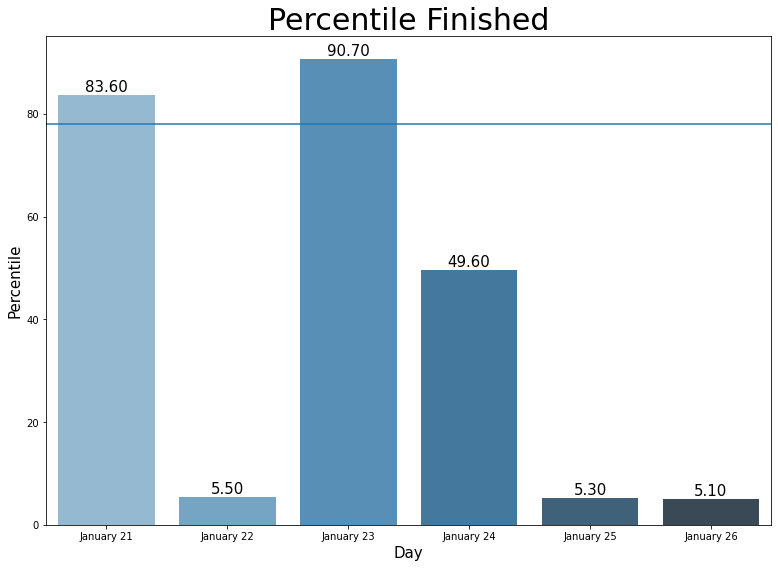

In [31]:
plt.figure(figsize=(13,9))

graph = sns.barplot(data = results,palette='Blues_d')
graph.axhline(78.0)

plt.title('Percentile Finished',size=30)
plt.ylabel('Percentile',size=15)
plt.xlabel('Day',size=15)

for bar in graph.patches: 
    graph.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 